# Loading Required Packages

In [1]:
from fish_helpers import *
from cellpose import models

# Dataset + Position

In [2]:
base_path = '/bigstore/Images2021/Zach/dredFISH/DPNMF+HV_2021Oct28/'
image_metadata = Metadata(base_path)
hybes = np.array([i for i in image_metadata.acqnames if 'hybe' in i])
posnames = np.unique(image_metadata.image_table[image_metadata.image_table.acq==hybes[0]].Position)
posname = posnames[0]

# Config

In [11]:
bitmap = [('RS0109_cy5', 'hybe2', 'FarRed'),
         ('RS0175_cy5', 'hybe3', 'FarRed'),
         ('RS0237_cy5', 'hybe4', 'FarRed'),
         ('RS0307_cy5', 'hybe5', 'FarRed'),
         ('RS0332_cy5', 'hybe6', 'FarRed'),
         ('RS0384_atto565', 'hybe10', 'FarRed'),
         ('RS0406_atto565', 'hybe11', 'FarRed'),
         ('RS0451_atto565', 'hybe12', 'FarRed'),
         ('RS0468_atto565', 'hybe13', 'FarRed'),
         ('RS0548_atto565', 'hybe14', 'FarRed'),
         ('RS64.0_atto565', 'hybe15', 'FarRed'),
         ('RS156.0_alexa488', 'hybe19', 'FarRed'),
         ('RS278.0_alexa488', 'hybe20', 'FarRed'),
         ('RS313.0_alexa488', 'hybe21', 'FarRed'),
         ('RS643.0_alexa488', 'hybe22', 'FarRed'),
         ('RS740.0_alexa488', 'hybe23', 'FarRed'),
         ('RS810.0_alexa488', 'hybe24', 'FarRed'),
         ('RSN9927.0_cy5', 'hybe7', 'FarRed'),
         ('RSN2336.0_cy5', 'hybe8', 'FarRed'),
         ('RSN1807.0_cy5', 'hybe9', 'FarRed'),
         ('RSN4287.0_atto565', 'hybe16', 'FarRed'),
         ('RSN1252.0_atto565', 'hybe17', 'FarRed'),
         ('RSN9535.0_atto565', 'hybe18', 'FarRed'),
              ('RS0095_cy5', 'hybe1', 'FarRed')]

In [18]:
pixel_size = 0.326

# Loading Raw Data

In [17]:
posname = posnames[10]
nucstain = np.array([i for i in image_metadata.acqnames if 'nucstain' in i])[-1]
nucstain_image = image_metadata.stkread(Position=posname,Channel='DeepBlue',acq=nucstain).mean(2).astype(float)
raw_dict = {hybe.split('_')[0]:image_metadata.stkread(Position=posname,Channel='FarRed',acq=hybe).mean(2).astype(float) for hybe in image_metadata.acqnames if 'hybe' in hybe}
background_dict = {'hybe'+strip.split('strip')[1].split('_')[0]:image_metadata.stkread(Position=posname,Channel='FarRed',acq=strip).mean(2).astype(float) for strip in image_metadata.acqnames if 'strip' in strip}
signal_dict = {hybe:raw_dict[hybe]-background_dict[hybe] for readout,hybe,channel in bitmap}
cytoplasm_image = np.dstack([signal_dict[hybe] for readout,hybe,channel in bitmap]).mean(2)

# Nuclear Segmentation

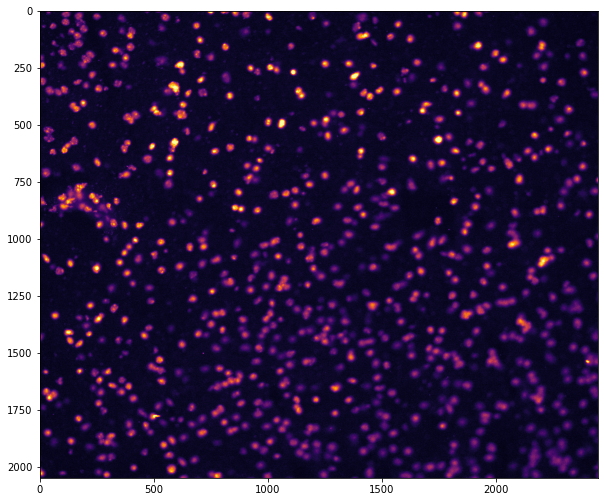

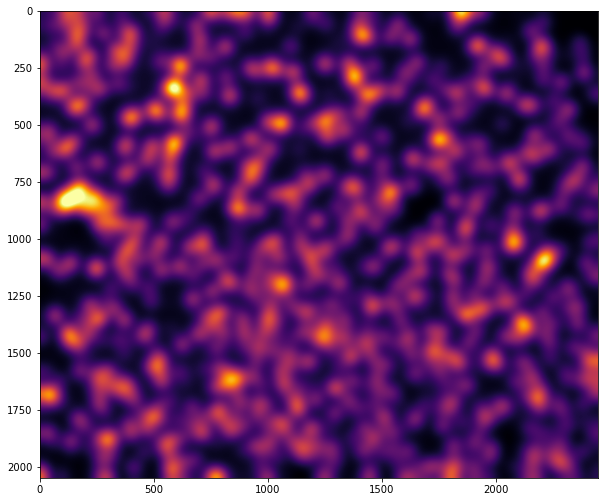

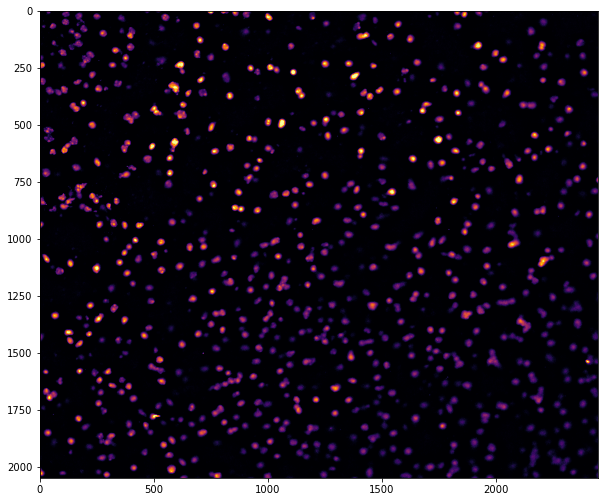

2021-11-15 16:30:54,490 [INFO] >>>> using CPU
2021-11-15 16:30:54,626 [INFO] ~~~ FINDING MASKS ~~~
2021-11-15 16:31:43,179 [INFO] >>>> TOTAL TIME 48.55 sec


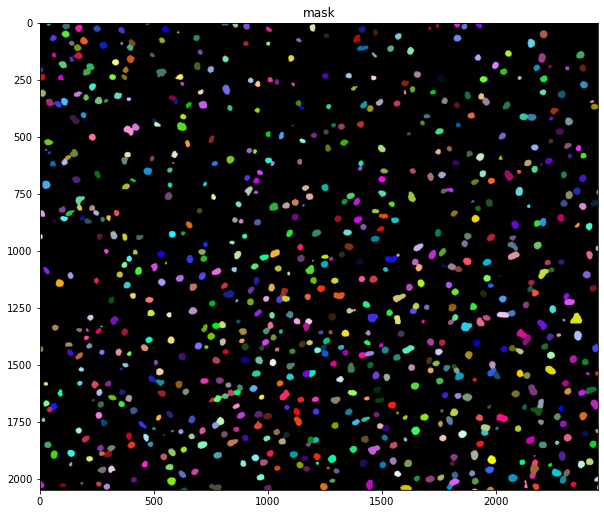

In [27]:
image = nucstain_image.copy()
""" Raw Image"""
Display(image)

""" Process Image """
bkg = gaussian_filter(image,10/pixel_size)
Display(bkg)
image = image-bkg
image[image<0] = 0
Display(image)
""" Segment Image """
model = models.Cellpose(model_type='nuclei',gpu=False)
raw_mask_image,flows,styles,diams = model.eval(image,
                                  diameter=10/pixel_size,
                                  channels=[0,0],
                                  flow_threshold=1,
                                  cellprob_threshold=0)
nuclei_mask = raw_mask_image
Display_mask(raw_mask_image)

# Cytoplasm Segmentation

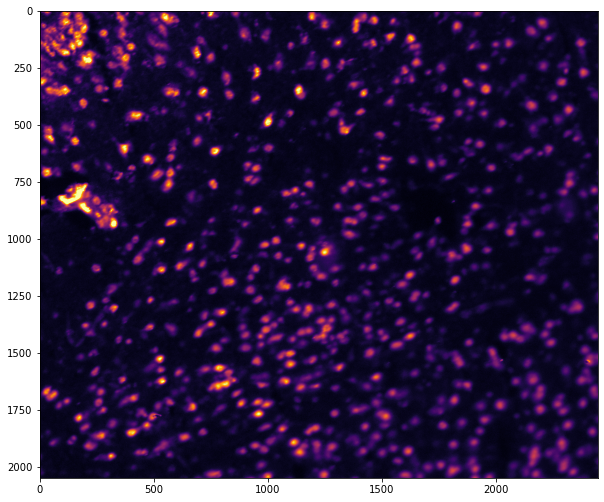

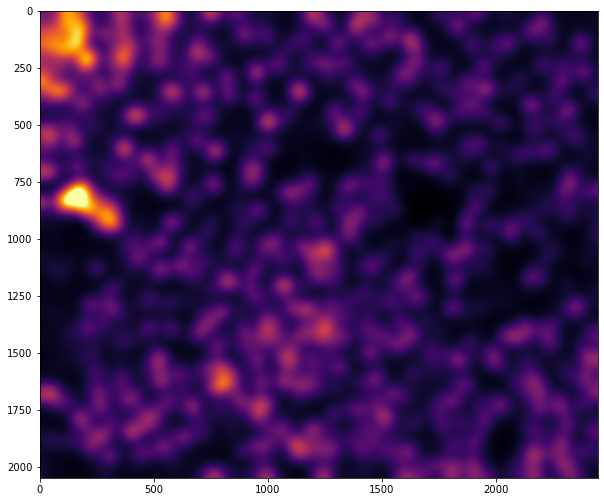

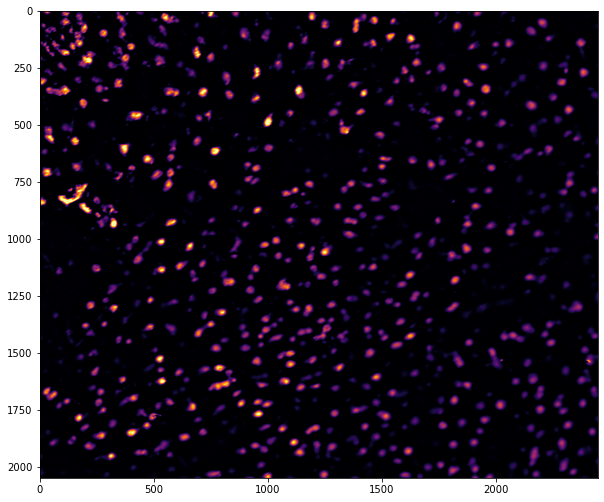

2021-11-15 16:20:49,989 [INFO] >>>> using CPU
2021-11-15 16:20:50,121 [INFO] ~~~ FINDING MASKS ~~~
2021-11-15 16:22:53,865 [INFO] >>>> TOTAL TIME 123.74 sec


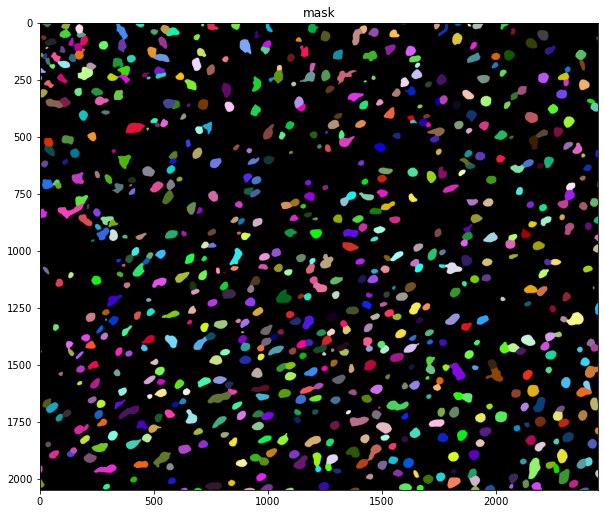

In [23]:
image = cytoplasm_image.copy()
""" Raw Image"""
Display(image)

""" Process Image """
bkg = gaussian_filter(image,10/pixel_size)
Display(bkg)
image = image-bkg
image[image<0] = 0
Display(image)
""" Segment Image """
model = models.Cellpose(model_type='cyto',gpu=False)
raw_mask_image,flows,styles,diams = model.eval(image,
                                  diameter=10/pixel_size,
                                  channels=[0,0],
                                  flow_threshold=1,
                                  cellprob_threshold=0)
Display_mask(raw_mask_image)

# Cytoplasm w/ Nuclei Segmentation

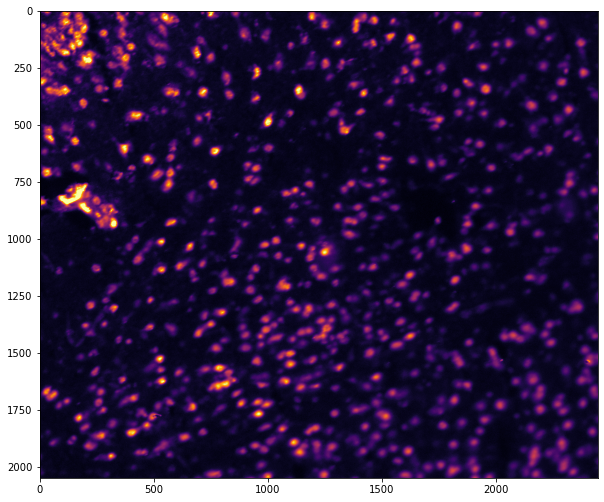

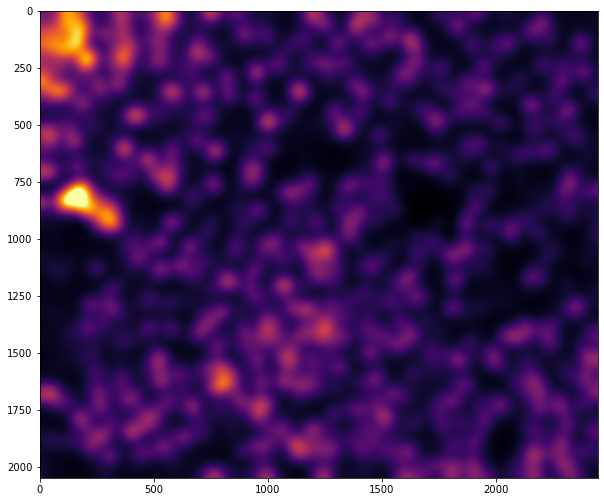

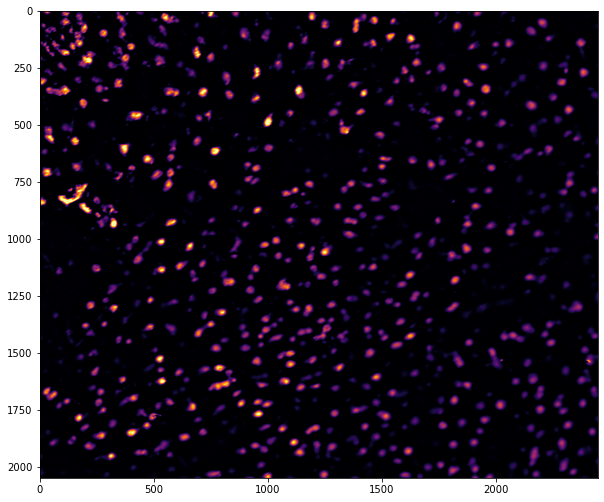

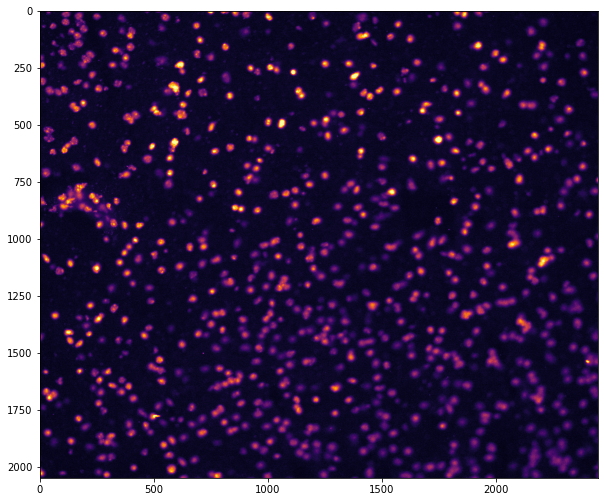

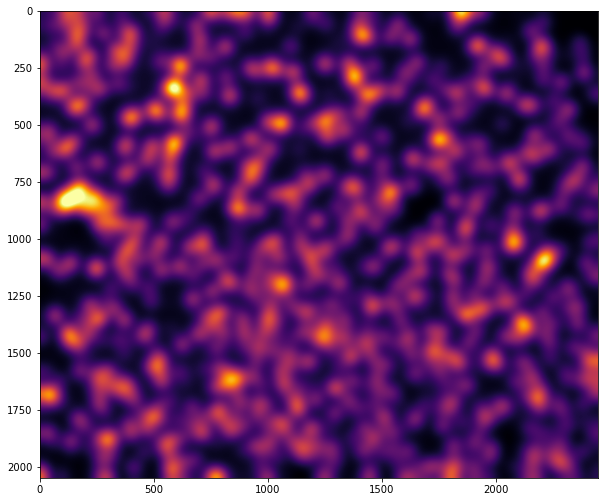

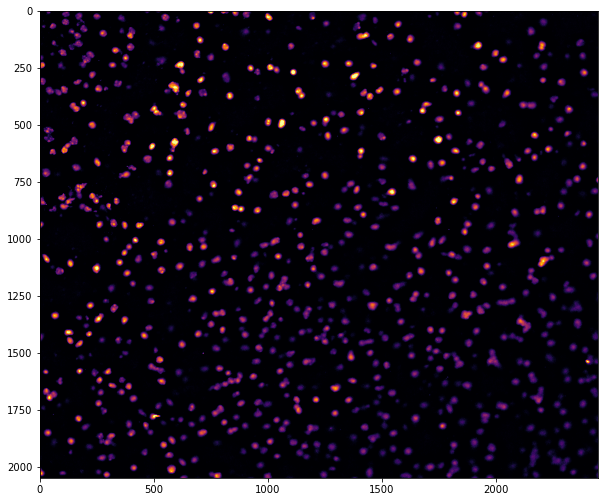

2021-11-15 16:31:55,890 [INFO] >>>> using CPU
2021-11-15 16:31:56,025 [INFO] ~~~ FINDING MASKS ~~~
2021-11-15 16:34:03,054 [INFO] >>>> TOTAL TIME 127.03 sec


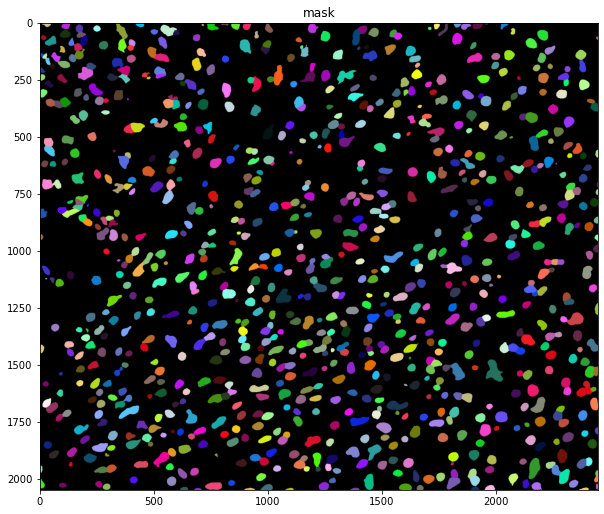

In [28]:
stk = np.dstack([cytoplasm_image.copy(),nucstain_image.copy(),np.zeros_like(cytoplasm_image.copy())])
""" Raw Image"""
image = cytoplasm_image.copy()
Display(image)

""" Process Image """
bkg = gaussian_filter(image,10/pixel_size)
Display(bkg)
image = image-bkg
image[image<0] = 0
Display(image)
stk[:,:,0] = image

""" Raw Image"""
image = nucstain_image.copy()
Display(image)

""" Process Image """
bkg = gaussian_filter(image,10/pixel_size)
Display(bkg)
image = image-bkg
image[image<0] = 0
Display(image)
stk[:,:,1] = image

""" Segment Image """
model = models.Cellpose(model_type='cyto',gpu=False)
raw_mask_image,flows,styles,diams = model.eval(stk,
                                  diameter=10/pixel_size,
                                  channels=[1,2],
                                  flow_threshold=1,
                                  cellprob_threshold=0)
cytoplasm_mask = raw_mask_image
Display_mask(raw_mask_image)

# Align Nuclei and Cytoplasm labels

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 794/794 [00:05<00:00, 156.28it/s]


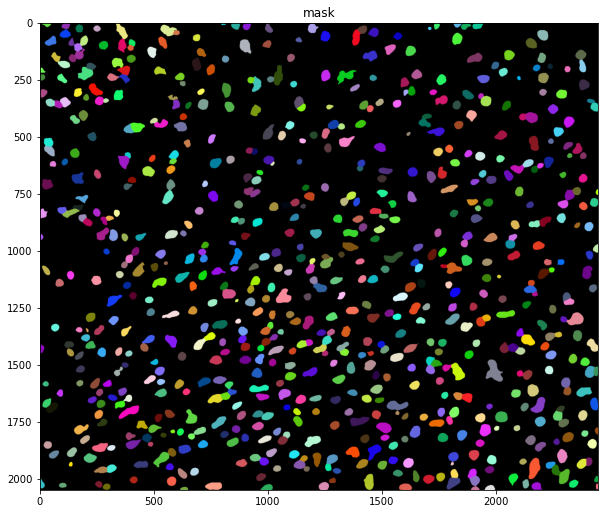

In [48]:
from scipy import stats
paired_nuclei_mask = nuclei_mask.copy()
labels = np.unique(nuclei_mask.ravel()[nuclei_mask.ravel()>0])
paired_cytoplasm_mask = np.zeros_like(cytoplasm_mask)
for label in tqdm(labels):
    m = nuclei_mask==label
    cyto_label = stats.mode(cytoplasm_mask[m]).mode[0]
    if cyto_label == 0:
        paired_nuclei_mask[m] = 0 # Eliminate Cell
        continue
    paired_cytoplasm_mask[cytoplasm_mask==cyto_label] = label
Display_mask(paired_cytoplasm_mask)

# Pulling Vectors

In [54]:
labels = np.unique(paired_nuclei_mask.ravel()[paired_nuclei_mask.ravel()>0])
nuclei_vectors = np.zeros([labels.shape[0],len(bitmap)])
cyto_vectors = np.zeros([labels.shape[0],len(bitmap)])
label_nuclei_coord_dict = {label:np.where(paired_nuclei_mask==label) for j,label in tqdm(enumerate(labels),total=labels.shape[0],desc='Generate Nuclei Coordinates')}
label_cyto_coord_dict = {label:np.where(paired_cytoplasm_mask==label) for j,label in tqdm(enumerate(labels),total=labels.shape[0],desc='Generate Cyto Coordinates')}
for i,(readout,hybe,channel) in enumerate(bitmap):
    image = signal_dict[hybe]
    for j,label in enumerate(labels):
        nuclei_vectors[j,i] = np.median(image[label_nuclei_coord_dict[label]])
        cyto_vectors[j,i] = np.median(image[label_cyto_coord_dict[label]])

Generate Label Coordinates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 773/773 [00:17<00:00, 43.25it/s]


# Generate Cell Metadata

In [57]:
cell_metadata = []
for j,label in tqdm(enumerate(labels),total=labels.shape[0],desc=hybe):
    nx,ny = label_nuclei_coord_dict[label]
    cx,cy = label_cyto_coord_dict[label]
    data = [label,nx.shape[0],nx.mean(),ny.mean(),np.median(nucstain_image[nx,ny]),cx.shape[0],cx.mean(),cy.mean(),np.median(cytoplasm_image[cx,cy])]
    cell_metadata.append(pd.DataFrame(data,index=['label',
                          'nuclei_size',
                          'nuclei_x',
                          'nuclei_y',
                          'nuclei_signal',
                          'cyto_size',
                          'cyto_x',
                          'cyto_y',
                          'cyto_signal']).T)
cell_metadata = pd.concat(cell_metadata,ignore_index=True)

hybe1:  12%|███████████████████████▎                                                                                                                                                                        | 94/773 [00:00<00:00, 939.35it/s]/tmp/ipykernel_31743/2840806385.py:5: RuntimeWarning: Mean of empty slice.
  data = [int(label),nx.shape[0],nx.mean(),ny.mean(),np.median(nucstain_image[nx,ny]),cx.shape[0],cx.mean(),cy.mean(),np.median(cytoplasm_image[cx,cy])]
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
hybe1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [58]:
cell_metadata

label  nuclei_size     nuclei_x     nuclei_y  nuclei_signal  cyto_size  \
0      2.0         68.0     1.794118  1958.147059         4334.0       85.0   
1      4.0        163.0     4.705521    37.846626         4286.0      482.0   
2      5.0        330.0     4.675758   810.600000         4606.0      145.0   
3      6.0        424.0     7.985849  1829.622642         4742.0      526.0   
4      7.0        397.0     8.740554   856.959698         4750.0      926.0   
..     ...          ...          ...          ...            ...        ...   
768  790.0        645.0  2037.131783   999.781395         4366.0     1036.0   
769  791.0        922.0  2037.363341  1605.114967         4270.0     1345.0   
770  792.0        342.0  2041.552632  1975.649123         4190.0      765.0   
771  793.0        249.0  2042.791165   632.441767         4366.0      400.0   
772  794.0        104.0  2044.836538  1906.548077         4230.0      457.0   

          cyto_x       cyto_y  cyto_signal  
0       2.423529  1957.423529   286.666667  
1       6.599585    29.670124  2634.729167  
2       4.096552   803.972414   720.000000  
3       7.859316  1830.893536   933.333333  
4      12.380130   858.053996  2069.041667  
..           ...          ...          ...  
768  2036.447876   997.407336  2961.083333  
769  2034.539033  1603.028253  2245.375000  
770  2038.224837  1974.558170  1669.375000  
771  2041.472500   632.477500   421.333333  
772  2040.840263  1909.017505  2010.666667  

[773 rows x 9 columns]

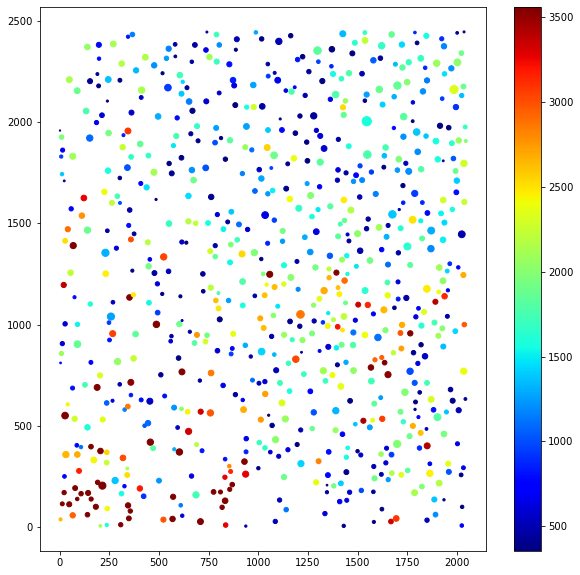

In [67]:
plt.figure(figsize=[10,10])
c = cell_metadata.cyto_signal
c[np.isnan(c)] = np.mean(c)
plt.scatter(cell_metadata.nuclei_x,cell_metadata.nuclei_y,s=cell_metadata.cyto_size/50,c=c,cmap='jet',vmin=np.percentile(c,5),vmax=np.percentile(c,95))
plt.colorbar()
plt.show()e

# Class

In [2]:
from MERFISH_Objects.FISHData import *
from datetime import datetime
from fish_helpers import *
from cellpose import models
class dredFISH_Position_Class(object):
    def __init__(self,
                 metadata_path,
                 dataset,
                 posname,
                 cword_config,
                 verbose=False):
        
        self.metadata_path = metadata_path
        self.dataset = dataset
        self.posname = posname
        self.cword_config = cword_config
        self.verbose = verbose
        self.proceed = True
        
        self.cword_config = cword_config
        self.merfish_config = importlib.import_module(self.cword_config)
        self.parameters = self.merfish_config.parameters
        self.fishdata = FISHData(os.path.join(self.metadata_path,self.parameters['fishdata']))
        self.bitmap = self.merfish_config.bitmap
        
        self.nucstain_acq = 'interpret'#self.parameters['nucstain_acq']
        self.total_acq = 'none'#self.parameters['total_acq']
        
    def run(self):
        self.check_data()
        if self.proceed:
            self.main()
    def update_user(self,message):
        i = [i for i in tqdm([],desc=str(datetime.now().strftime("%H:%M:%S"))+' '+str(message))]
        
    def main(self):
        if self.verbose:
            self.update_user('Processing Position '+self.posname)
        self.config_data()
        self.load_data()
        self.segmentation()
        if self.cell_metadata.shape[0]>0:
            self.pull_vectors()
            self.save_data()
        
    def check_data(self):
        if self.parameters['overwite']==False:
            self.data = self.fishdata.load_data('h5ad',dataset=self.dataset,posname=self.posname)
            if isinstance(self.data,type(None))==False:
                self.proceed==False
            self.nuclei_mask = self.fishdata.load_data('nuclei_mask',dataset=self.dataset,posname=self.posname)
            self.cytoplasm_mask = self.fishdata.load_data('cytoplasm_mask',dataset=self.dataset,posname=self.posname)
            self.total_mask = self.fishdata.load_data('total_mask',dataset=self.dataset,posname=self.posname)
        
    def config_data(self):
        if self.verbose:
            self.update_user('Loading Metadata')
        self.image_metadata = Metadata(self.metadata_path)
        
    def load_data(self):
        """ Load Nuclei Image """
        if self.verbose:
            self.update_user('Loading Nuclei Image')
        if self.nucstain_acq=='interpret':
            self.nucstain_acq = np.array([i for i in self.image_metadata.acqnames if 'nucstain' in i])[-1]
        self.nucstain_image = self.image_metadata.stkread(Position=posname,Channel=self.parameters['nucstain_channel'],acq=self.nucstain_acq).mean(2).astype(float)
        
        """ Load Raw Data """
        if self.verbose:
            self.update_user('Loading Raw Data')
        self.raw_dict = {hybe.split('_')[0]:self.image_metadata.stkread(Position=self.posname,
                                                                        Channel=self.parameters['total_channel'],
                                                                        acq=hybe).mean(2).astype(float) for hybe in self.image_metadata.acqnames if 'hybe' in hybe}
        self.background_dict = {'hybe'+strip.split('strip')[1].split('_')[0]:self.image_metadata.stkread(Position=self.posname,
                                                                                                         Channel=self.parameters['total_channel'],
                                                                                                         acq=strip).mean(2).astype(float) for strip in self.image_metadata.acqnames if 'strip' in strip}
        
        """ Subtract Background """
        if self.verbose:
            self.update_user('Subtracting Background')
        self.signal_dict = {hybe:self.raw_dict[hybe]-self.background_dict[hybe] for readout,hybe,channel in self.bitmap}
        
        """ Load Total Image """
        if self.verbose:
            self.update_user('Loading Total Image')
        if self.total_acq=='interpret':
            self.total_acq = np.array([i for i in self.image_metadata.acqnames if 'nucstain' in i])[-1]
            self.total_image = self.image_metadata.stkread(Position=self.posname,
                                                           Channel=self.parameters['total_channel'],
                                                           acq=self.total_acq).mean(2).astype(float)
        elif self.total_acq=='none':
            self.total_image = np.dstack([self.signal_dict[hybe] for readout,hybe,channel in self.bitmap]).mean(2)
        else:
            self.total_image = self.image_metadata.stkread(Position=self.posname,
                                                           Channel=self.parameters['total_channel'],
                                                           acq=self.total_acq).mean(2).astype(float)
            
    def process_image(self,image):
        bkg = gaussian_filter(image,self.parameters['segment_diameter']/self.parameters['segment_pixel_size'])
        image = image-bkg
        image[image<0] = 0
        return image
    
    def nuclei_segmentation(self):      
        """ Segment Image """
        if self.verbose:
            self.update_user('Segmenting Nuclei')
        torch.cuda.empty_cache() 
        model = models.Cellpose(model_type='nuclei',gpu=self.parameters['segment_gpu'])
        raw_mask_image,flows,styles,diams = model.eval(self.process_image(self.nucstain_image.copy()),
                                          diameter=self.parameters['segment_diameter']/self.parameters['segment_pixel_size'],
                                          channels=[0,0],
                                          flow_threshold=1,
                                          cellprob_threshold=0)
        del model
        torch.cuda.empty_cache() 
        self.nuclei_mask = raw_mask_image
        
    def total_segmentation(self):
        stk = np.dstack([self.process_image(self.total_image.copy()),self.process_image(self.nucstain_image.copy()),np.zeros_like(self.total_image.copy())])
        """ Segment Image """
        if self.verbose:
            self.update_user('Segmenting Total')
        torch.cuda.empty_cache() 
        model = models.Cellpose(model_type='cyto',gpu=self.parameters['segment_gpu'])
        raw_mask_image,flows,styles,diams = model.eval(stk,
                                          diameter=self.parameters['segment_diameter']/self.parameters['segment_pixel_size'],
                                          channels=[1,2],
                                          flow_threshold=1,
                                          cellprob_threshold=0)
        del model
        torch.cuda.empty_cache() 
        self.total_mask = raw_mask_image

    def generate_cell_metadata(self):
        if self.verbose:
            self.update_user('Generating Cell Metadata')
        labels = np.unique(self.nuclei_mask.ravel()[self.nuclei_mask.ravel()>0])
        self.label_nuclei_coord_dict = {label:np.where(self.nuclei_mask==label) for j,label in enumerate(labels)}
        self.label_cyto_coord_dict = {label:np.where((self.cytoplasm_mask==label)) for j,label in enumerate(labels)}
        self.label_total_coord_dict = {label:np.where(self.total_mask==label) for j,label in enumerate(labels)}
        if labels.shape[0]==0:
            self.cell_metadata = pd.DataFrame(index=['label','pixel_x','pixel_y','nuclei_size','nuclei_signal','cyto_size','cyto_signal','total_size','total_signal']).T
        else:
            cell_metadata = []
            for j,label in enumerate(labels):
                nx,ny = self.label_nuclei_coord_dict[label]
                cx,cy = self.label_cyto_coord_dict[label]
                tx,ty = self.label_total_coord_dict[label]
                data = [label,nx.mean(),ny.mean(),
                        nx.shape[0],np.median(self.total_image[nx,ny]),
                        cx.shape[0],np.median(self.total_image[cx,cy]),
                        tx.shape[0],np.median(self.total_image[tx,ty])]
                cell_metadata.append(pd.DataFrame(data,index=['label','pixel_x','pixel_y','nuclei_size','nuclei_signal','cyto_size','cyto_signal','total_size','total_signal']).T)
            self.cell_metadata = pd.concat(cell_metadata,ignore_index=True)
            self.cell_metadata['posname'] = self.posname
            position_x,position_y = self.image_metadata.image_table[self.image_metadata.image_table.Position==self.posname].XY.iloc[0]
            self.cell_metadata['posname_stage_x'] = position_x
            self.cell_metadata['posname_stage_y'] = position_y
        
    def segmentation(self):
        """ Segment """
        self.nuclei_segmentation()
        self.total_segmentation()
        
        """ Align Nuclei and Total Labels"""
        if self.verbose:
            self.update_user('Aligning Segmentation labels')
        from scipy import stats
        paired_nuclei_mask = self.nuclei_mask.copy()
        labels = np.unique(self.nuclei_mask.ravel()[self.nuclei_mask.ravel()>0])
        paired_total_mask = np.zeros_like(self.total_mask)
        for label in labels:
            m = self.nuclei_mask==label
            cyto_label = stats.mode(self.total_mask[m]).mode[0]
            if cyto_label == 0:
                paired_nuclei_mask[m] = 0 # Eliminate Cell
                continue
            paired_total_mask[self.total_mask==cyto_label] = label
        self.nuclei_mask = paired_nuclei_mask
        self.total_mask = paired_total_mask
        self.cytoplasm_mask = paired_total_mask
        self.cytoplasm_mask[self.nuclei_mask>0] = 0
        self.generate_cell_metadata()

    def pull_vectors(self):
        if self.verbose:
            self.update_user('Pulling Vectors')
        labels = np.unique(self.nuclei_mask.ravel()[self.nuclei_mask.ravel()>0])
        nuclei_vectors = np.zeros([labels.shape[0],len(self.bitmap)])
        cyto_vectors = np.zeros([labels.shape[0],len(self.bitmap)])
        total_vectors = np.zeros([labels.shape[0],len(self.bitmap)])
        for i,(readout,hybe,channel) in enumerate(self.bitmap):
            image = self.signal_dict[hybe] # Alternatively Load Images Here maybe save on memory
            for j,label in enumerate(labels):
                nuclei_vectors[j,i] = np.median(image[self.label_nuclei_coord_dict[label]])
                cyto_vectors[j,i] = np.median(image[self.label_cyto_coord_dict[label]])
                total_vectors[j,i] = np.median(image[self.label_total_coord_dict[label]])
        self.nuclei_vectors = nuclei_vectors
        self.cyto_vectors = cyto_vectors
        self.total_vectors = total_vectors
        
    def save_data(self):
        if self.verbose:
            self.update_user('Saving Data and Masks')
        data = anndata.AnnData(X=self.nuclei_vectors,var=pd.DataFrame(index=np.array([h for r,h,c in self.bitmap])),obs=pd.DataFrame(index=self.cell_metadata.index.astype(str)))
        data.layers['nuclei_vectors'] = self.nuclei_vectors
        data.layers['cytoplasm_vectors'] = self.cyto_vectors
        data.layers['total_vectors'] = self.total_vectors
        for column in self.cell_metadata.columns:
            data.obs[column] = np.array(self.cell_metadata[column])
        data.obs_names_make_unique()
        self.data = data
        self.fishdata.add_and_save_data(self.data,
                                        dtype='h5ad',
                                        dataset=self.dataset,
                                        posname=self.posname)
        self.fishdata.add_and_save_data(self.nuclei_mask,
                                        dtype='nuclei_mask',
                                        dataset=self.dataset,
                                        posname=self.posname)
        self.fishdata.add_and_save_data(self.cytoplasm_mask,
                                        dtype='cytoplasm_mask',
                                        dataset=self.dataset,
                                        posname=self.posname)
        self.fishdata.add_and_save_data(self.total_mask,
                                        dtype='total_mask',
                                        dataset=self.dataset,
                                        posname=self.posname)


2021-11-16 17:05:15,604 [INFO] WRITING LOG OUTPUT TO /home/zach/.cellpose/run.log


In [2]:
metadata_path = '/bigstore/Images2021/Zach/dredFISH/DPNMF+HV_2021Oct28/'
if metadata_path[-1]=='/':
    dataset = metadata_path.split('/')[-2]
else:
    dataset = metadata_path.split('/')[-1]
posname = 'Pos108'
cword_config = 'dredfish_config'
import time
start = time.time()
print(str(datetime.now().strftime("%H:%M:%S")))

pos_class = dredFISH_Position_Class(metadata_path,dataset,posname,cword_config,verbose=True)
pos_class.main()
print(str(datetime.now().strftime("%H:%M:%S")))
print(time.time()-start)

16:26:05


16:26:06 Processing Position Pos108: 0it [00:00, ?it/s]
16:26:06 Loading Metadata: 0it [00:00, ?it/s]
16:26:09 Loading Nuclei Image: 0it [00:00, ?it/s]
16:26:09 Loading Raw Data: 0it [00:00, ?it/s]
16:26:14 Subtracting Background: 0it [00:00, ?it/s]
16:26:15 Loading Total Image: 0it [00:00, ?it/s]
16:26:17 Segmenting Nuclei: 0it [00:00, ?it/s]


2021-11-16 16:26:25,853 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 16:26:25,856 [INFO] >>>> using GPU
2021-11-16 16:26:28,080 [INFO] ~~~ FINDING MASKS ~~~


/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


2021-11-16 16:26:36,511 [INFO] >>>> TOTAL TIME 8.43 sec


16:26:40 Segmenting Total: 0it [00:00, ?it/s]

2021-11-16 16:26:40,548 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 16:26:40,548 [INFO] >>>> using GPU
2021-11-16 16:26:40,690 [INFO] ~~~ FINDING MASKS ~~~


2021-11-16 16:27:02,475 [INFO] >>>> TOTAL TIME 21.78 sec


16:27:02 Aligning Segmentation labels: 0it [00:00, ?it/s]
16:27:07 Generating Cell Metadata: 0it [00:00, ?it/s]
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
16:28:01 Pulling Vectors: 0it [00:00, ?it/s]
16:28:08 Saving Data and Masks: 0it [00:00, ?it/s]
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'posname' as categorical


16:28:09
123.79360961914062


/tmp/ipykernel_5957/2930616272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c[np.isnan(c)] = np.mean(c)


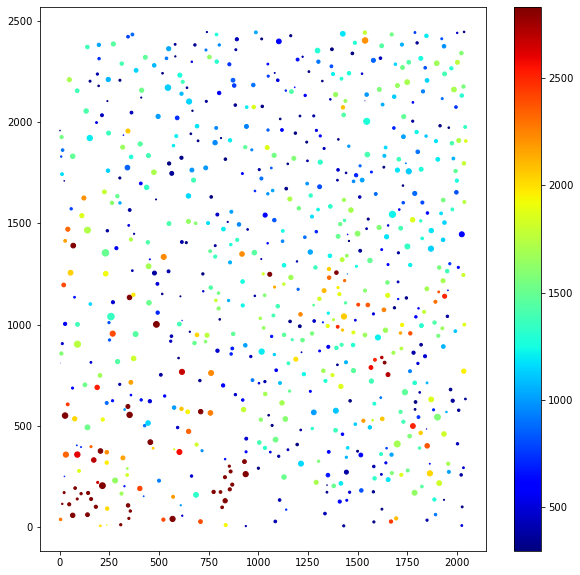

In [3]:
plt.figure(figsize=[10,10])
c = pos_class.cell_metadata.total_signal
c[np.isnan(c)] = np.mean(c)
plt.scatter(pos_class.cell_metadata.pixel_x,pos_class.cell_metadata.pixel_y,s=pos_class.cell_metadata.total_size/50,c=c,cmap='jet',vmin=np.percentile(c,5),vmax=np.percentile(c,95))
plt.colorbar()
plt.show()

In [ ]:
""" Simple For Loop 100 Positions in ~4 Hours """
metadata_path = '/bigstore/Images2021/Zach/dredFISH/DPNMF+HV_2021Oct28/'
if metadata_path[-1]=='/':
    dataset = metadata_path.split('/')[-2]
else:
    dataset = metadata_path.split('/')[-1]
cword_config = 'dredfish_config'
image_metadata = Metadata(metadata_path)
hybes = np.array([i for i in image_metadata.acqnames if 'hybe' in i])
posnames = np.unique(image_metadata.image_table[image_metadata.image_table.acq==hybes[0]].Position)
for posname in tqdm(posnames):
    pos_class = dredFISH_Position_Class(metadata_path,dataset,posname,cword_config,verbose=False)
    pos_class.main()

  0%|                                                   | 0/124 [00:00<?, ?it/s]

2021-11-16 17:05:38,615 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 17:05:38,619 [INFO] >>>> using GPU
2021-11-16 17:05:40,856 [INFO] ~~~ FINDING MASKS ~~~


/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


2021-11-16 17:05:47,502 [INFO] >>>> TOTAL TIME 6.65 sec
2021-11-16 17:05:51,635 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 17:05:51,637 [INFO] >>>> using GPU
2021-11-16 17:05:51,780 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 17:06:04,638 [INFO] >>>> TOTAL TIME 12.86 sec


  1%|▎                                        | 1/124 [00:45<1:32:31, 45.14s/it]

2021-11-16 17:06:14,011 [INFO] ** TORCH CUDA version installed and working. **
2021-11-16 17:06:14,014 [INFO] >>>> using GPU
2021-11-16 17:06:16,201 [INFO] ~~~ FINDING MASKS ~~~


In [ ]:
""" Multiprocess 100 Positions in ? Hours """
def wrapper(data):
    pos_class = dredFISH_Position_Class(data['metadata_path'],data['dataset'],data['posname'],data['cword_config'],verbose=False)
    pos_class.main()
    return data['posname']

import multiprocessing
base_path = '/bigstore/Images2021/Zach/dredFISH/DPNMF+HV_2021Oct28/'
if base_path[-1]=='/':
    dataset = base_path.split('/')[-2]
else:
    dataset = base_path.split('/')[-1]
image_metadata = Metadata(base_path)
hybes = np.array([i for i in image_metadata.acqnames if 'hybe' in i])
posnames = np.unique(image_metadata.image_table[image_metadata.image_table.acq==hybes[0]].Position)
np.random.shuffle(posnames)
Input = []
for posname in posnames:
    data = {'metadata_path':base_path,'dataset':dataset,'posname':posname,'cword_config':'dredfish_config'}
    Input.append(data)
np.random.shuffle(Input)
with multiprocessing.Pool(10) as p:
    for posname,img in tqdm(p.imap(wrapper,Input),total=len(Input),desc=str(datetime.now().strftime("%H:%M:%S"))+' Processing dredfish'):
        pass

13:27:20 Processing dredfish:   0%|                                                                                                                                                                                   | 0/124 [00:00<?, ?it/s]

2021-11-16 13:28:00,855 [INFO] >>>> using CPU
2021-11-16 13:28:02,013 [INFO] >>>> using CPU
2021-11-16 13:28:03,636 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:04,603 [INFO] >>>> using CPU
2021-11-16 13:28:05,035 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:05,347 [INFO] >>>> using CPU
2021-11-16 13:28:06,784 [INFO] >>>> using CPU
2021-11-16 13:28:06,808 [INFO] >>>> using CPU
2021-11-16 13:28:07,047 [INFO] >>>> using CPU
2021-11-16 13:28:07,218 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:07,243 [INFO] >>>> using CPU
2021-11-16 13:28:07,626 [INFO] >>>> using CPU
2021-11-16 13:28:08,105 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:08,273 [INFO] >>>> using CPU
2021-11-16 13:28:10,103 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:10,123 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:10,839 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:11,299 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:12,138 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16 13:28:14,209 [INFO] ~~~ FINDING MASKS ~~~
2021-11-16

In [1]:
import torch
torch.cuda.empty_cache() 